In [49]:
import numpy as np
import math
import torch
from torch import nn
import torch.nn.functional as F


import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt

from tempfile import TemporaryDirectory

from Inference.FuNNeVI import FuNNeVI
from Models import BigGenerator, SLPGenerator
from Metrics import KL, sw, FunKL, FunSW

from tqdm import trange

print(torch.__version__)


1.7.0.dev20200706


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
from Experiments.foong import Setup
setup=Setup(device)
model=setup._model

In [4]:
class FuNNeVI():
    def __init__(self, loglikelihood, prior, projection, n_samples_FU, ratio_ood, p,
                 kNNE, n_samples_KL, n_samples_LL,
                 max_iter, learning_rate, min_lr, patience, lr_decay,
                 device, rho=1.):
        self.loglikelihood=loglikelihood
        self.prior=prior
        self.projection=projection
        self.n_samples_FU=n_samples_FU
        self.ratio_ood=ratio_ood
        self.kNNE=kNNE
        self.n_samples_KL=n_samples_KL
        self.n_samples_LL=n_samples_LL
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.min_lr = min_lr
        self.patience = patience
        self.lr_decay = lr_decay
        self.device = device
    
        self._best_score=float('inf')
        
        self.p=p
        self.rho=rho 


    def ELBO(self,GeN,m_MCL=100,n_LL=1000):
        #compute ELBO of GeN accurately
        
        theta=GeN(self.n_samples_KL)
        theta_prior=self.prior(self.n_samples_KL)
        theta_proj=torch.Tensor(m_MCL, self.n_samples_KL, self.n_samples_FU).to(self.device)
        theta_prior_proj=torch.Tensor(m_MCL, self.n_samples_KL, self.n_samples_FU).to(self.device)
        for i in range(m_MCL):
            theta_proj[i], theta_prior_proj[i] = self.projection(theta, theta_prior, self.n_samples_FU, self.ratio_ood)
        
        K=batchKL(theta_proj, theta_prior_proj,k=self.kNNE,device=self.device,p=self.p)
        LL = self.loglikelihood(GeN(n_LL)).mean()
        L = K - LL
        return L
    
    def _KL(self,GeN):
        
        theta=GeN(self.n_samples_KL) #variationnel
        theta_prior=self.prior(self.n_samples_KL) #prior

        theta_proj, theta_prior_proj = self.projection(theta, theta_prior, self.n_samples_FU, self.ratio_ood)

        K=KL(theta_proj, theta_prior_proj,k=self.kNNE,device=self.device,p=self.p)
        return K

        
             

    def run(self, GeN, show_fn=None):
        optimizer = torch.optim.Adam(GeN.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=self.patience, factor=self.lr_decay)

        self.score_elbo = []
        self.score_KL = []
        self.score_LL = []
        self.score_lr = []
        with trange(self.max_iter) as tr:
            for t in tr:
                optimizer.zero_grad()
                """
                theta=GeN(self.n_samples_KL)
                theta_prior=self.prior(self.n_samples_KL)

                theta_proj, theta_prior_proj=self.projection(theta, theta_prior, self.n_samples_FU, self.ratio_ood)
                K=KL(theta_proj, theta_prior_proj,k=self.kNNE,device=self.device)

                LL = self.loglikelihood(GeN(self.n_samples_LL)).mean()
                L = K - LL
                """
                #TODO explore hyperparameter lambda*K
                K = self._KL(GeN) #KL(Q_var,Prior)
                L=self.rho*K
                L.backward()

                lr = optimizer.param_groups[0]['lr']

                #scheduler.step(L.item())
                scheduler.step(K.item())

                tr.set_postfix(KL=K.item(), lr=lr)

                if lr < self.min_lr:
                    break

                optimizer.step()    
        
        return 

# Target density #

In [5]:
loglikelihood=setup.loglikelihood
projection=setup.projection
size_sample=setup.n_train_samples
param_count=setup.param_count
model=setup._model


def prior(n):
    return .5*torch.randn(size=(n,param_count), device=device)

size_sample,param_count

(120, 151)

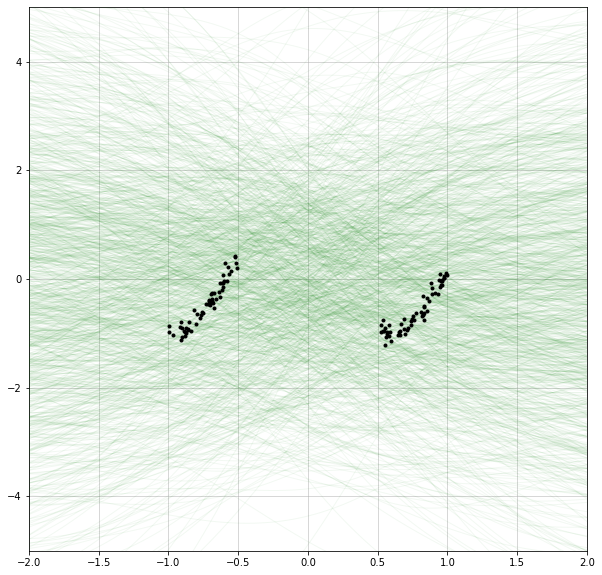

In [15]:
fig=setup.makePlot(prior(1000),device)

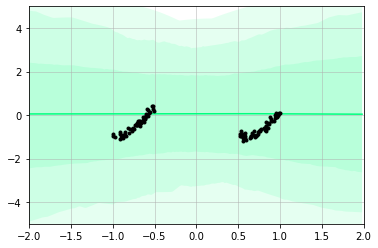

In [7]:
fig=setup.makePlotCI(prior(1000),device)

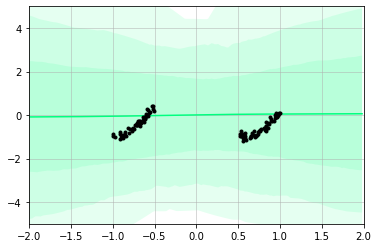

In [8]:
fig=setup.makePlotCI(prior(1000),device)

In [9]:
G=BigGenerator(5, param_count,device).to(device)
G.model

Sequential(
  (0): Linear(in_features=5, out_features=20, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=20, out_features=40, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=40, out_features=151, bias=True)
)

In [10]:

torch.nn.init.normal_(G.model[4].weight,mean=0., std=1.)
torch.nn.init.normal_(G.model[4].bias,mean=0., std=1.)

Parameter containing:
tensor([ 0.5789,  1.8717,  0.9886, -0.8739, -2.5387,  2.0998, -0.8980, -0.1186,
        -0.3125, -0.4847, -0.3410, -0.4076,  1.0775,  1.2997,  0.9781,  0.3222,
         0.5161, -0.9908,  3.1030,  1.0680, -1.5915,  0.0987, -1.5826, -0.8751,
        -1.8109,  0.4825, -0.5949, -0.8122,  0.7554,  1.3985,  0.6804,  0.5302,
         0.0451, -0.3090,  1.4120,  0.8147,  0.1133,  0.4453,  1.5104, -0.4377,
        -0.5356, -0.2954, -2.0526, -0.5173, -0.2655,  1.2168,  0.5474, -0.1128,
         0.5721, -1.0249,  0.8732,  0.7127,  1.6974,  0.9826,  0.4281,  2.5292,
        -0.5319, -1.4639, -0.8838,  0.6474, -0.7717, -0.1445, -1.8345,  1.2249,
         1.2561, -1.1379, -0.5715,  0.0426, -0.9605, -0.7091,  0.0400, -1.9067,
         0.2774, -0.2099, -0.7788, -0.4826, -0.1885,  1.2348, -0.1621, -1.5257,
         2.1743, -0.8911,  0.5527, -0.0425,  0.4608,  0.4305, -2.6392, -1.4278,
        -1.3370,  0.6906, -0.0685, -1.6751,  1.1719,  1.4595, -2.3081, -1.1467,
         1.1450,  

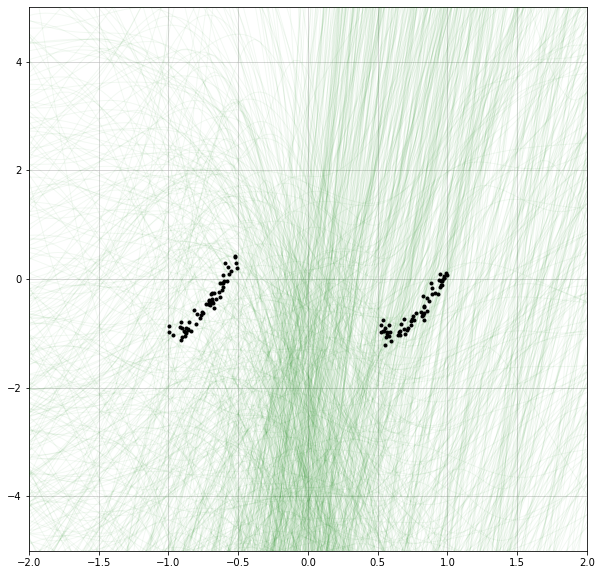

In [11]:
fig=setup.makePlot(G(1000).detach(),device)

# Generative Network #

In [12]:

optimizer = FuNNeVI(loglikelihood, prior, projection, n_samples_FU=30, ratio_ood=1., p=2,
                          kNNE=1, n_samples_KL=500, n_samples_LL=0, 
                          max_iter=10000, learning_rate=5e-3, min_lr=1e-3, patience=1000, lr_decay=0.7,
                          device=device)

optimizer.run(G)

 77%|███████▋  | 7743/10000 [00:45<00:13, 169.44it/s, KL=-3.03, lr=0.00084]


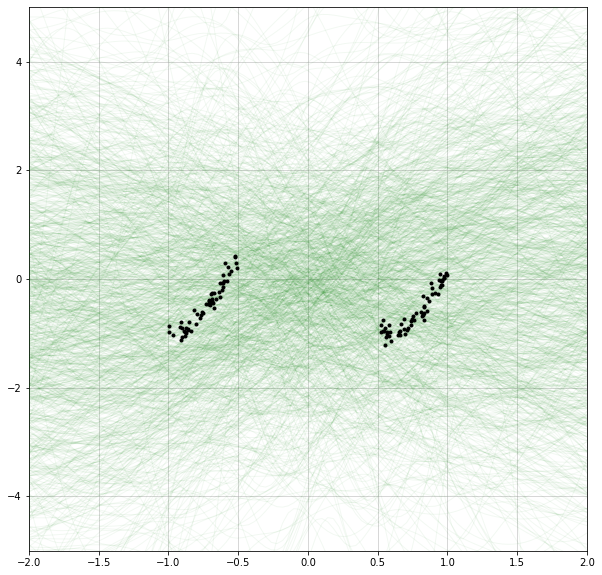

In [13]:
fig=setup.makePlot(G(1000).detach(),device)

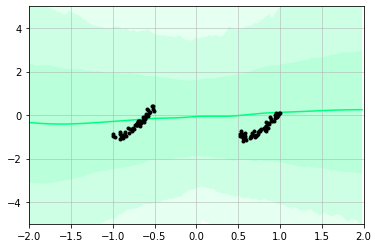

In [14]:
fig=setup.makePlotCI(G(1000).detach(),device)


# KL between distributions

In [16]:
K=KL(G(10000).detach(),prior(10000))
print('In parameter space: '+str(K.item()))

In parameter space: 343.0760192871094


In [17]:
K=KL(prior(10000), G(10000).detach())
print('In parameter space: '+str(K.item()))

In parameter space: 108.73958587646484


In [18]:
sw(G(1000).detach().cpu(),prior(1000).cpu(),'cpu')

1.0746951759910608

In [19]:
def projection_(s,t,m):
    return projection(s,t,m,1.0)
F_K=FunKL(G(10000).detach(),prior(10000),projection_, device)
print('In function space: '+str(F_K.item()))

In function space: tensor(3.5839)


In [20]:
F_SW=FunSW(G(10000).detach(),prior(10000),projection_,device)

In [21]:
F_SW

tensor(0.0242)

# T-sne

In [40]:
X=torch.linspace(-2,2,100).to(device)
theta_g=G(1000).detach()
theta_p=prior(1000)
theta=torch.cat([theta_g,theta_p],dim=0)
colors=torch.cat([0.25*torch.ones(1000),0.*torch.ones(1000)]).numpy()
theta_g.shape

torch.Size([1000, 151])

In [41]:
from sklearn.manifold import TSNE
myTSNE=TSNE(n_components=2,init='pca',perplexity=35)
X_embedded_ =myTSNE.fit_transform(theta.cpu())
print(myTSNE.kl_divergence_)
X_embedded_.shape

1.894204020500183


(2000, 2)

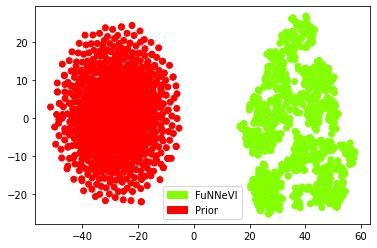

In [42]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import matplotlib.patches as mpatches

import matplotlib.cm as cm
cmap = cm.hsv


#fig = plt.figure(figsize=(10, 10))




G1_patch = mpatches.Patch(color=cmap(0.25), label='FuNNeVI')
G2_patch = mpatches.Patch(color=cmap(0.), label='Prior')



#ax = fig.gca(projection='3d')
plt.scatter(X_embedded_[:,0],X_embedded_[:,1],color=cmap(colors),cmap=cmap) #,X_embedded_[:,2]
#plt.title('3D t-SNE of '+str(param_count)+'-dimensional transformed noise')
#ax.view_init(elev=20., azim=270)

plt.legend(handles=[G1_patch,G2_patch])
#plt.title('parameters distributions')
plt.show()


In [46]:
X=torch.linspace(-2,2,200).to(device)
theta_g=model(X,G(1000).detach()).squeeze()
theta_p=model(X,prior(1000)).squeeze()
theta=torch.cat([theta_g,theta_p],dim=0)
colors=torch.cat([torch.zeros(1000),0.1*torch.ones(1000)]).numpy()
theta_g.shape

torch.Size([1000, 200])

In [47]:
from sklearn.manifold import TSNE
myTSNE=TSNE(n_components=2,init='pca',perplexity=35)
X_embedded_f =myTSNE.fit_transform(theta.cpu())
print(myTSNE.kl_divergence_)
X_embedded_.shape

0.7529272437095642


(2000, 2)

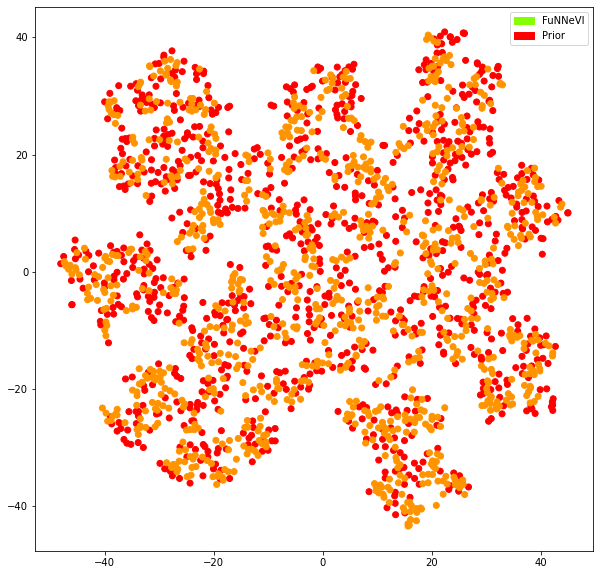

In [48]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import matplotlib.patches as mpatches

import matplotlib.cm as cm
cmap = cm.hsv


fig = plt.figure(figsize=(10, 10))




G1_patch = mpatches.Patch(color=cmap(0.25), label='FuNNeVI')
G2_patch = mpatches.Patch(color=cmap(0.), label='Prior')



#ax = fig.gca(projection='3d')
plt.scatter(X_embedded_f[:,0],X_embedded_f[:,1],color=cmap(colors),cmap=cmap) #,X_embedded_[:,2]
#plt.title('3D t-SNE of '+str(param_count)+'-dimensional transformed noise')
#ax.view_init(elev=20., azim=270)

plt.legend(handles=[G1_patch,G2_patch])
#plt.title('function distributions')
plt.show()
